https://www.kamp-ai.kr/front/dataset/AiDataDetail.jsp?AI_SEARCH=%EB%B6%88%EB%9F%89&page=1&DATASET_SEQ=10&EQUIP_SEL=&GUBUN_SEL=&FILE_TYPE_SEL=&WDATE_SEL=

In [1]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import graphviz
import seaborn as sns
from IPython.display import Image
import pydotplus
import pandas as pd
import numpy as np
import os
from pandas_profiling import ProfileReport

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/dataset/pasteurizer.csv')
df.head()

,STD_DT,MIXA_PASTEUR_STATE,MIXB_PASTEUR_STATE,MIXA_PASTEUR_TEMP,MIXB_PASTEUR_TEMP,INSP
0,2020-03-04 6:00,1.0,1.0,551.0,524.0,OK
1,2020-03-04 6:30,1.0,1.0,584.0,536.0,OK
2,2020-03-04 7:00,1.0,1.0,584.0,536.0,OK
3,2020-03-04 7:30,1.0,1.0,585.0,536.0,OK
4,2020-03-04 8:00,1.0,1.0,585.0,536.0,OK


In [4]:
df = df.dropna()

In [5]:
df.isna().sum()

STD_DT                0
MIXA_PASTEUR_STATE    0
MIXB_PASTEUR_STATE    0
MIXA_PASTEUR_TEMP     0
MIXB_PASTEUR_TEMP     0
INSP                  0
dtype: int64

In [18]:
plt.hist(df['MIXA_PASTEUR_STATE'])

(array([9383.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         100.]),
 array([      0. ,  560384.1, 1120768.2, 1681152.3, 2241536.4, 2801920.5,
        3362304.6, 3922688.7, 4483072.8, 5043456.9, 5603841. ]),
 <BarContainer object of 10 artists>)

In [21]:
df = df[df.MIXA_PASTEUR_STATE < 2]

In [22]:
X = df.iloc[:, 1:5].values
y = df.iloc[:, -1:].values
y = np.where(y =='OK',1,0)
y = y.ravel()
print(X.shape, y.shape)

(9383, 4) (9383,)


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=1)

In [24]:
feature_names = df.columns.tolist()
feature_names = feature_names[1:5]
target_name = np.array(['0','1'])

F1 score 살펴보기

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve

In [56]:
def get_clf_eval(y_test=None, pred=None):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  f1 = f1_score(y_test, pred)
  roc_auc = roc_auc_score(y_test, pred)
  print('오차 행렬')
  print(confusion)
  print('정확도: {0: .4f}, 정밀도: {1: .4f}, 재현율: {2: .4f}, F1: {3: .4f}, AUC:{4: .4f}'.format(accuracy, precision, recall, f1, roc_auc))

### 의사결정트리

In [25]:
dt_clf = DecisionTreeClassifier(max_depth=3)
dt_clf = dt_clf.fit(X_train, y_train)
dt_prediction = dt_clf.predict(X_test)

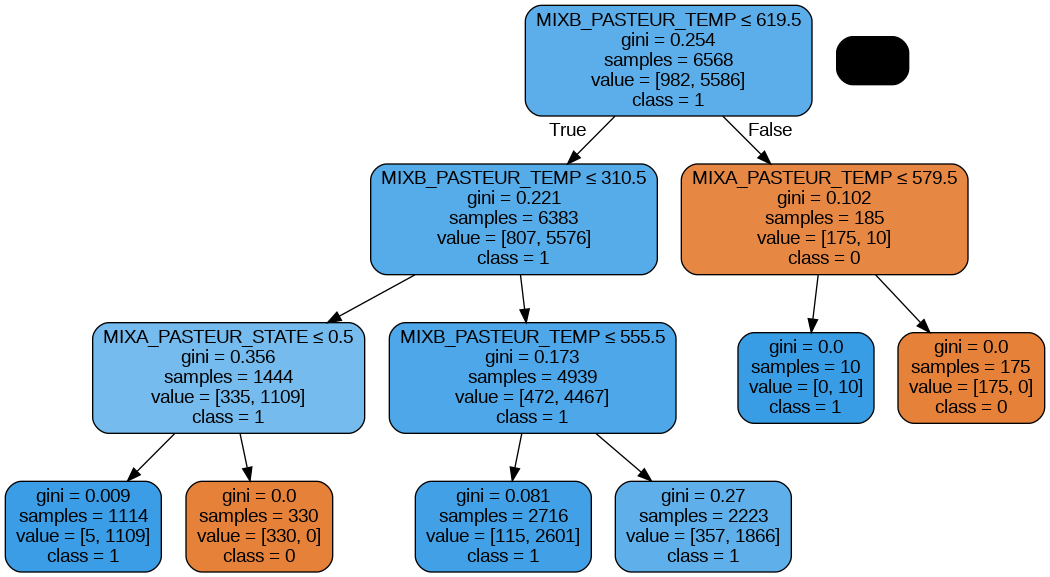

In [26]:
dt_dot_data = tree.export_graphviz(dt_clf,
                                   feature_names = feature_names,
                                   class_names = target_name,
                                   filled = True, rounded = True,
                                   special_characters = True)
dt_graph = pydotplus.graph_from_dot_data(dt_dot_data)
Image(dt_graph.create_png())

In [58]:
print("<의사결정트리>")
get_clf_eval(y_test, dt_prediction)

<의사결정트리>
오차 행렬
[[ 237  196]
 [   1 2381]]
정확도:  0.9300, 정밀도:  0.9239, 재현율:  0.9996, F1:  0.9603, AUC: 0.7735


### XGBoost

### K-근접 이웃

### 선형 회귀

In [93]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)
NN = model.predict(X_test).flatten()

NN_prediction = np.array([])
for i in NN:
  if i>=0.7:
    NN_prediction = np.append(NN_prediction, np.array([1]))
  else:
    NN_prediction = np.append(NN_prediction, np.array([0]))

get_clf_eval(y_test, NN_prediction)

오차 행렬
[[ 114  319]
 [   7 2375]]
정확도:  0.8842, 정밀도:  0.8816, 재현율:  0.9971, F1:  0.9358, AUC: 0.6302


### 로지스틱 회귀

In [82]:
# Scikit-learn 로지스틱 회귀 모델 학습
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)
NN = model.predict(X_test).flatten()
get_clf_eval(y_test, NN)

오차 행렬
[[  22  411]
 [   0 2382]]
정확도:  0.8540, 정밀도:  0.8528, 재현율:  1.0000, F1:  0.9206, AUC: 0.5254


In [77]:
# numpy로 구현한 로지스틱 회귀 모델 학습
class logisticRegression:
  def __init__(self, lr=0.01, num_iter = 1000, fit_intercept=True, verbose = False):
    self.lr = lr
    self.num_iter = num_iter
    self.fit_intercept= fit_intercept
    self.verbose = verbose
    self.eps = 1e-10
    self.threshold = 0.5
    self.loss_history = list()

  def __add_intercept(self, X):
    intercept = np.ones((X.shape[0],1))
    return np.concatenate((intercept,X),axis=1)

  def __sigmoid(self,z):
    return 1/(1+np.exp(-z))

  def __loss(self, h, y):
    return (-y*np.log(h+self.eps)-(1-y)*np.log(1-h+self.eps)).mean()

  def fit(self, X, y):
    if self.fit_intercept:
      X = self.__add_intercept(X)

    # weights initialization
    self.theta = np.zeros(X.shape[1])

    for i in range(self.num_iter):
        logit = np.dot(X, self.theta)
        hypothesis = self.__sigmoid(logit)
        gradient = np.dot(X.T, (hypothesis - y)) / y.size
        self.theta -= self.lr*gradient

        if self.verbose == True and i%10 == 0:
          loss = self.__loss(hypothesis, y)
          print(f'epoch: {i}  loss: {loss} ')
          self.loss_history.append(loss)
    return self.loss_history

  def predict_prob(self, X):
    if self.fit_intercept:
      X = self.__add_intercept(X)
    return self.__sigmoid(np.dot(X, self.theta))

  def predict(self, X):
    predicted_labels = np.where(self.predict_prob(X) > self.threshold, 1, 0)
    return predicted_labels

model = logisticRegression(lr = 0.0001, num_iter = 100, verbose = True)
model.fit(X_train, y_train)
NN = model.predict(X_test).flatten()
print(NN)
get_clf_eval(y_test, NN)


epoch: 0  loss: 0.6931471803599453 
epoch: 10  loss: 1.631648012132257 
epoch: 20  loss: 3.051254246236101 
epoch: 30  loss: 1.5186378945270542 
epoch: 40  loss: 3.2535906861973607 
epoch: 50  loss: 0.9244850888372632 
epoch: 60  loss: 1.373830957134832 
epoch: 70  loss: 3.312187223814895 
epoch: 80  loss: 1.2893939596466033 
epoch: 90  loss: 2.8028794826601287 
[1 1 1 ... 1 1 1]
오차 행렬
[[   0  433]
 [   0 2382]]
정확도:  0.8462, 정밀도:  0.8462, 재현율:  1.0000, F1:  0.9167, AUC: 0.5000


### SVM machine

### NN(신경망)

In [55]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(4, )))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid')) 
model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])
model.fit(X_train, y_train, epochs=4, batch_size=512)

NN = model.predict(X_test).flatten()

NN_prediction = np.array([])
for i in NN:
  if i>=0.5:
    NN_prediction = np.append(NN_prediction, np.array([1]))
  else:
    NN_prediction = np.append(NN_prediction, np.array([0]))

get_clf_eval(y_test, NN_prediction)

Epoch 1/4
13/13 [==============================] - 1s 5ms/step - loss: 42.0074 - acc: 0.1475
Epoch 2/4
13/13 [==============================] - 0s 4ms/step - loss: 2.0256 - acc: 0.6431
Epoch 3/4
13/13 [==============================] - 0s 3ms/step - loss: 1.0773 - acc: 0.8176
Epoch 4/4
88/88 [==============================] - 0s 2ms/step
오차 행렬
[[  25  408]
 [  70 2312]]
정확도:  0.8302, 정밀도:  0.8500, 재현율:  0.9706, F1:  0.9063, AUC: 0.5142


In [44]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(4, )))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid')) 
model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])
model.fit(X_train, y_train, epochs=4, batch_size=512)

NN = model.predict(X_test).flatten()

NN_prediction = np.array([])
for i in NN:
  if i>=0.5:
    NN_prediction = np.append(NN_prediction, np.array([1]))
  else:
    NN_prediction = np.append(NN_prediction, np.array([0]))

get_clf_eval(y_test, NN_prediction)

Epoch 1/4
13/13 [==============================] - 1s 4ms/step - loss: 40.5558 - acc: 0.1539
Epoch 2/4
13/13 [==============================] - 0s 4ms/step - loss: 0.9789 - acc: 0.8433
Epoch 3/4
13/13 [==============================] - 0s 4ms/step - loss: 0.6121 - acc: 0.8372
Epoch 4/4
88/88 [==============================] - 0s 3ms/step
오차 행렬
[[ 161  272]
 [   4 2378]]
정확도:  0.9020, 정밀도:  0.8974, 재현율:  0.9983, F1:  0.9452, AUC: 0.6851
